In [90]:
import numpy as np
import pandas as pd
import pandas_ta as ta

from plotly import graph_objects as go
from tqdm import tqdm

import logging

log = logging.Logger(name="logger", level=logging.INFO)

In [91]:
xau = pd.read_csv("data/xauusd_1h.csv", index_col="datetime", parse_dates=['datetime'])
xau.head()

,open,high,low,close,volume
datetime,,,,,
2010-01-03 22:00:00,1097.880005,1097.880005,1097.449951,1097.449951,2
2010-01-03 23:00:00,1097.680054,1100.599976,1095.979980,1095.979980,919
2010-01-04 00:00:00,1096.010010,1096.869995,1093.449951,1094.839966,1596
2010-01-04 01:00:00,1094.869995,1095.959961,1094.239990,1095.699951,869
2010-01-04 02:00:00,1095.670044,1099.150024,1095.630005,1098.329956,1054


In [92]:
xau.index[0]

Timestamp('2010-01-03 22:00:00')

In [93]:
def pivot_high(highs:pd.Series, window:int=14):
    len = highs.size
    ph = np.zeros(shape=(len, ), dtype=float)
    
    for i in range(window, len-window):
        if highs.iloc[i] == highs.iloc[i-window:i+window].max():
            ph[i] = highs.iloc[i]
    return ph

def pivot_low(lows:pd.Series, window:int=14):
    len = lows.size
    pl = np.zeros(shape=(len, ), dtype=float)
    
    for i in range(window, len-window):
        if lows.iloc[i] == lows.iloc[i-window:i+window].min():
            pl[i] = lows.iloc[i]
    return pl

In [94]:
def pivots(highs:pd.Series, lows:pd.Series, window:int) -> pd.Series:
    len = highs.size
    if lows.size != len:
        raise BufferError("`highs` and `lows` must have the same size!")
    pivots = pd.Series(data=0, index=highs.index)
    pivot_values = pd.Series(data=0, index=highs.index, dtype=np.float64)
    last_pivot = -1
    last_pivot_index = 0
    # last_pivot_value = highs.iloc[0]
    
    for i in tqdm(range(window, len-window)):
        if highs.iloc[i] == highs.iloc[i-window:i+window].max():
            if last_pivot == 1 and highs.iloc[last_pivot_index] < highs.iloc[i]:     # Previous pivot is a lower pivot high?!
                pivots.iloc[last_pivot_index] = 0       # Invalidate the previous pivot high
                pivot_values.iloc[last_pivot_index] = 0
                last_pivot_index = i                    # Set new pivot high
                pivots.iloc[last_pivot_index] = last_pivot
                pivot_values.iloc[last_pivot_index] = highs.iloc[last_pivot_index]
            elif last_pivot == -1:  # Previous pivot is a pivot low?!
                last_pivot_index = i            # Set pivot high
                last_pivot = 1
                pivots.iloc[last_pivot_index] = last_pivot
                pivot_values.iloc[last_pivot_index] = highs.iloc[last_pivot_index]
        elif lows.iloc[i] == lows.iloc[i-window:i+window].min():
            if last_pivot == -1 and lows.iloc[last_pivot_index] > lows.iloc[i]:    # Previous pivot is a higher pivot low?!
                pivots.iloc[last_pivot_index] = 0       # Invalidate the previous pivot low
                pivot_values.iloc[last_pivot_index] = 0
                last_pivot_index = i                    # Set new pivot low
                pivots.iloc[last_pivot_index] = last_pivot
                pivot_values.iloc[last_pivot_index] = lows.iloc[last_pivot_index]
            elif last_pivot == 1:       # Previous pivot is a pivot high
                last_pivot_index = i            # Set pivot low
                last_pivot = -1
                pivots.iloc[last_pivot_index] = last_pivot
                pivot_values.iloc[last_pivot_index] = lows.iloc[last_pivot_index]
    return pivots, pivot_values

In [95]:
xau['pivots'], xau['pivot_values'] = pivots(xau['high'], xau['low'], window=3)

100%|██████████| 89874/89874 [00:14<00:00, 6351.47it/s]


In [97]:
def plot_data(df):
    fig = go.Figure(
        data=[go.Candlestick(x=df.index,
                            close=df['close'],
                            open=df['open'],
                            low=df['low'],
                            high=df['high'])]
    )

    fig.update_layout(title="XAUUSD - H1",
                    xaxis_title="Date Time",
                    yaxis_title="Price",
                    xaxis=dict(type="category"))

    fig.show()

In [98]:
xau[xau['pivots'] == 1].index



DatetimeIndex(['2010-01-04 14:00:00', '2010-01-05 12:00:00',
               '2010-01-06 04:00:00', '2010-01-06 09:00:00',
               '2010-01-06 19:00:00', '2010-01-07 06:00:00',
               '2010-01-07 14:00:00', '2010-01-08 07:00:00',
               '2010-01-11 00:00:00', '2010-01-11 13:00:00',
               ...
               '2024-10-09 11:00:00', '2024-10-10 03:00:00',
               '2024-10-10 14:00:00', '2024-10-11 06:00:00',
               '2024-10-11 16:00:00', '2024-10-14 06:00:00',
               '2024-10-14 20:00:00', '2024-10-15 16:00:00',
               '2024-10-16 13:00:00', '2024-10-17 02:00:00'],
              dtype='datetime64[ns]', name='datetime', length=7589, freq=None)

In [99]:
xau['pivot_values'].loc[xau['pivot_values'] != 0]

datetime
2010-01-04 14:00:00    1123.920044
2010-01-04 18:00:00    1115.719971
2010-01-05 12:00:00    1128.859985
2010-01-05 18:00:00    1115.310059
2010-01-06 04:00:00    1124.875000
                          ...     
2024-10-15 16:00:00    2668.965088
2024-10-16 00:00:00    2658.800049
2024-10-16 13:00:00    2685.465088
2024-10-16 16:00:00    2666.794922
2024-10-17 02:00:00    2684.939941
Name: pivot_values, Length: 15177, dtype: float64

In [100]:
def head_and_shoulders(df:pd.DataFrame, threshold:int, log:logging.Logger) -> pd.Series:
    # if ['pivots', 'open', 'close'] not in df.columns.to_list():
        # raise ValueError("The columns `['pivots', 'open', 'close']` must exist...")

    buy_sell = pd.Series(data=0, index=df.index)
    len = df.shape[0]
    print(len, end="\n\n\n")
    pip_value = 0.1
    
    pivots_iloc = np.where(df['pivots'] != 0)[0]
    pivots_index = df.iloc[pivots_iloc].index
    
    for i in tqdm(range(len)):
        prev_5_pivots_index = pivots_index[pivots_index < df.index[i]]
        # print(prev_5_pivots_index)
        if prev_5_pivots_index.size < 5:
            continue
        else:
            prev_5_pivots_index = prev_5_pivots_index[-5:]
        prev_5_pivots = df['pivots'].loc[prev_5_pivots_index]
        prev_5_pivot_values = df['pivot_values'].loc[prev_5_pivots_index]

        if prev_5_pivots.loc[prev_5_pivots_index[0]] == 1:
            log.info("Start pivot high on left shoulder!")
            # if np.abs(prev_5_pivot_values.iloc[0] - prev_5_pivot_values.iloc[4]) < threshold * pip_value:
            shoulders = prev_5_pivot_values.iloc[0]
            if np.abs(prev_5_pivot_values.iloc[1] - prev_5_pivot_values.iloc[3]) < threshold * pip_value:
                neck_line = prev_5_pivot_values.iloc[1]
                if prev_5_pivot_values.iloc[2] > prev_5_pivot_values.iloc[0]:
                    if df['close'].iloc[i-1] < neck_line and df['open'].iloc[i-1] > neck_line:
                        buy_sell.iloc[i] = -1   # Sell
            
    return buy_sell

In [101]:
log.setLevel(logging.DEBUG)
buy_sell = head_and_shoulders(xau, 5, log=log)

89880




100%|██████████| 89880/89880 [00:59<00:00, 1507.91it/s]


In [103]:
xau['buy_sell'] = buy_sell

buy_sell.loc[buy_sell != 0].count()

60

In [104]:
buy_sell.index.size, xau.index.size

(89880, 89880)

In [138]:

def plot_candlestick(df:pd.DataFrame):
    fig = go.Figure(data=[go.Candlestick(
        x=df.index,
        close=df.close,
        open=df.open,
        high=df.high,
        low=df.low,
        # name="XAU_USD -- H1 -- OANDA",
        )])

    fig.update_layout(
        width=1200,
        height=800,
        plot_bgcolor='black',
        paper_bgcolor='black',
        font=dict(color='white'),
        xaxis=dict(type='category',
                   showgrid=False,
                   zeroline=False),
        yaxis=dict(showgrid=False,
                   zeroline=False)
    )

    fig.show()

In [139]:
plot_candlestick(xau.iloc[0:500])

In [111]:
xau_cap = xau.rename(columns={
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
})

In [159]:
import backtrader as bt
from backtesting.backtesting import Strategy
from backtesting.lib import Sequence

class SIGNAL(bt.Indicator):
    lines = ('signal', )
    params = ()
    def __init__(self):
        self.lines.signal = bt.feeds.PandasData(dataname=pd.DataFrame(xau['buy_sell'], columns=['buy_sell']))

def signal():
    return xau['buy_sell']


class HnSStrategy(Strategy):       
    sl_points = 200
    point_size = .01
    rrr = 1.5
    lot_size = 0.1

    def init(self):
        super().init()
        self.signal = self.I(signal, name="BUY/SELL")

    def next(self):
        super().next()
        if self.position:
            return

        if self.signal == -1:
            sl = self.data.Close[-1] + self.sl_points * self.point_size
            print(self.data.Close[-1])
            tp = self.data.Close[-1] - self.rrr * self.sl_points * self.point_size
            self.sell(size=self.lot_size, sl=sl, tp=tp, limit=None)
    

In [162]:
from backtesting.backtesting import Backtest

params = {'sl_points': 200,
          'rrr': 1.5}

bt = Backtest(data=xau_cap, strategy=HnSStrategy, cash=100_000.0, commission=0)

results = bt.run()

1131.5899658203125
1119.7099609375
1115.510009765625
1333.1800537109375
1430.56005859375
1480.0140380859375
1572.7769775390625
1558.1939697265625
1618.85498046875
1622.8740234375
1619.5469970703125
1731.93798828125
1263.9759521484375
1305.135986328125
1207.157958984375
1197.196044921875
1187.9599609375
1187.0469970703125
1069.8179931640625
1238.949951171875
1332.9659423828125
1338.052978515625
1142.634033203125
1135.384033203125
1266.199951171875
1334.447021484375
1325.9119873046875
1316.407958984375
1265.8599853515625
1221.9410400390625
1291.8680419921875
1289.1719970703125
1315.1080322265625
1302.248046875
1290.428955078125
1274.27001953125
1543.5279541015625
1724.926025390625
1691.199951171875
1828.1300048828125
1782.8360595703125
1853.1700439453125
1861.2049560546875
1839.5400390625
1700.199951171875
1785.8599853515625
1752.4549560546875
1750.9449462890625
1828.875
1939.010009765625
1950.5400390625
1945.449951171875
1911.60498046875
1923.81005859375
1873.0699462890625
2008.72497558

<Axes: xlabel='datetime'>

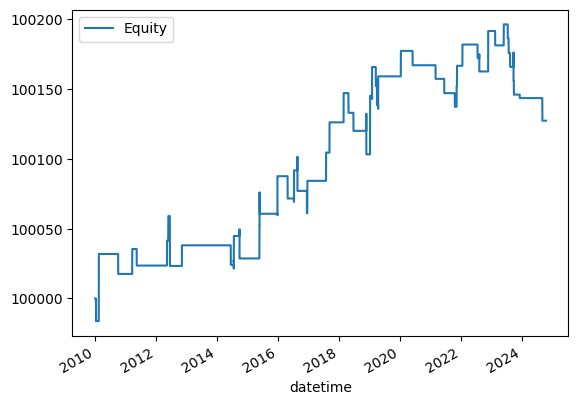

In [174]:
from matplotlib import pyplot as plt

results['_equity_curve'].plot(y='Equity')


In [109]:
params = {'sl_points': 50,
          'rrr': 2.0}

engine = bt.Cerebro()
engine.broker.setcash(100_000.0)        # USD

# engine.add_signal(bt.SIGNAL_SHORT, SIGNAL)
engine.addstrategy(HnSStrategy)

feed = engine.adddata(bt.feeds.PandasData(dataname=xau))